In [1]:
# Cell 1: Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import welch, find_peaks
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Cell 2: Check our data
data_dir = '../data/processed'
files = os.listdir(data_dir)
print(f"📁 Found {len(files)} files in {data_dir}/")

# List files
ecg_files = sorted([f for f in files if '_ecg.npy' in f])
label_files = sorted([f for f in files if '_labels.npy' in f])

print(f"\n📊 ECG files: {len(ecg_files)}")
print(f"🏷️  Label files: {len(label_files)}")

print("\nFirst 5 ECG files:")
for f in ecg_files[:5]:
    print(f"  {f}")

print("\nFirst 5 label files:")
for f in label_files[:5]:
    print(f"  {f}")

📁 Found 106 files in ../data/processed/

📊 ECG files: 70
🏷️  Label files: 35

First 5 ECG files:
  a01_ecg.npy
  a02_ecg.npy
  a03_ecg.npy
  a04_ecg.npy
  a05_ecg.npy

First 5 label files:
  a01_labels.npy
  a02_labels.npy
  a03_labels.npy
  a04_labels.npy
  a05_labels.npy


In [3]:
# Cell 3: Load and explore a01 record
record_name = 'a01'
ecg = np.load(f'{data_dir}/{record_name}_ecg.npy')
labels = np.load(f'{data_dir}/{record_name}_labels.npy')

print(f"📈 Record: {record_name}")
print(f"   ECG shape: {ecg.shape}")
print(f"   ECG duration: {len(ecg)/100/60:.1f} minutes (sampled at 100 Hz)")
print(f"   ECG range: [{ecg.min():.3f}, {ecg.max():.3f}]")
print(f"   ECG mean: {ecg.mean():.3f}, std: {ecg.std():.3f}")

print(f"\n🏷️  Labels shape: {labels.shape}")
print(f"   Total minutes: {len(labels)}")

# Count labels
apnea_count = np.sum(labels == 'A')
normal_count = np.sum(labels == 'N')
other_labels = [l for l in labels if l not in ['A', 'N']]

print(f"   Apnea (A): {apnea_count} minutes ({apnea_count/len(labels)*100:.1f}%)")
print(f"   Normal (N): {normal_count} minutes ({normal_count/len(labels)*100:.1f}%)")
print(f"   Other labels: {len(other_labels)} ({set(other_labels) if other_labels else 'None'})")

# Find first and last apnea events
apnea_indices = np.where(labels == 'A')[0]
if len(apnea_indices) > 0:
    print(f"\n🔍 First apnea at minute: {apnea_indices[0]}")
    print(f"   Last apnea at minute: {apnea_indices[-1]}")
    print(f"   Apnea minutes (first 10): {apnea_indices[:10]}")

📈 Record: a01
   ECG shape: (2957000,)
   ECG duration: 492.8 minutes (sampled at 100 Hz)
   ECG range: [-1.655, 2.440]
   ECG mean: 0.001, std: 0.244

🏷️  Labels shape: (489,)
   Total minutes: 489
   Apnea (A): 470 minutes (96.1%)
   Normal (N): 19 minutes (3.9%)
   Other labels: 0 (None)

🔍 First apnea at minute: 13
   Last apnea at minute: 488
   Apnea minutes (first 10): [13 14 15 16 17 18 19 20 21 22]


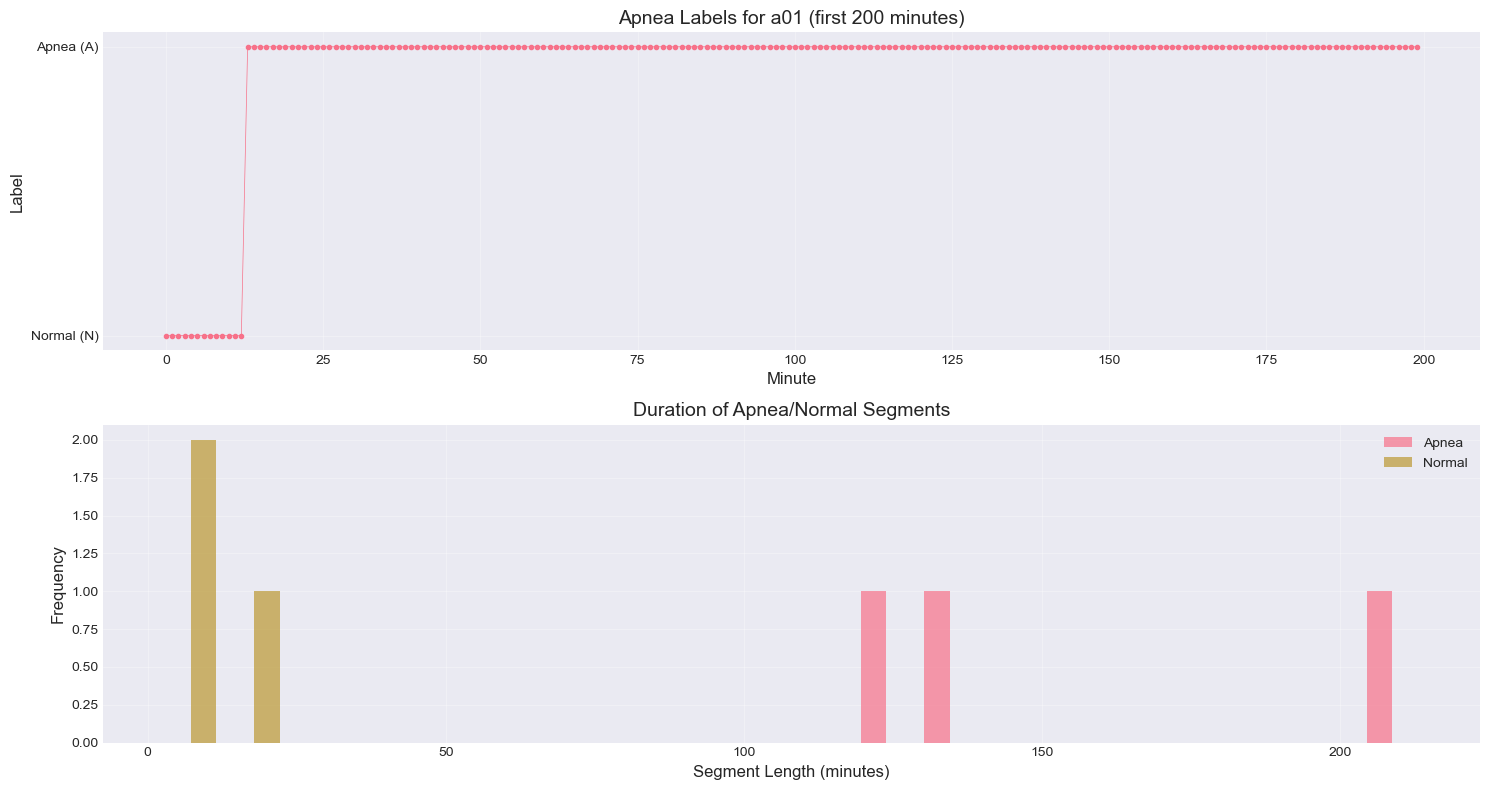

📊 Segment Analysis:
   Apnea segments: 3
   Normal segments: 3
   Avg apnea segment: 156.7 minutes
   Avg normal segment: 6.3 minutes


In [4]:
# Cell 4: Visualize labels
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: First 200 minutes of labels
time_minutes = np.arange(len(labels))
label_numeric = np.zeros(len(labels))
label_numeric[labels == 'A'] = 1
label_numeric[labels == 'N'] = 0

axes[0].plot(time_minutes[:200], label_numeric[:200], 'o-', markersize=3, linewidth=0.5)
axes[0].set_title(f'Apnea Labels for {record_name} (first 200 minutes)', fontsize=14)
axes[0].set_xlabel('Minute', fontsize=12)
axes[0].set_ylabel('Label', fontsize=12)
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['Normal (N)', 'Apnea (A)'])
axes[0].grid(True, alpha=0.3)

# Plot 2: Histogram of apnea/normal segments
apnea_segments = []
normal_segments = []
current_segment = []
current_label = labels[0]

for i, label in enumerate(labels):
    if label == current_label:
        current_segment.append(i)
    else:
        if current_label == 'A':
            apnea_segments.append(len(current_segment))
        elif current_label == 'N':
            normal_segments.append(len(current_segment))
        current_segment = [i]
        current_label = label

# Add last segment
if current_label == 'A':
    apnea_segments.append(len(current_segment))
elif current_label == 'N':
    normal_segments.append(len(current_segment))

axes[1].hist([apnea_segments, normal_segments], bins=20, label=['Apnea', 'Normal'], alpha=0.7)
axes[1].set_title('Duration of Apnea/Normal Segments', fontsize=14)
axes[1].set_xlabel('Segment Length (minutes)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Segment Analysis:")
print(f"   Apnea segments: {len(apnea_segments)}")
print(f"   Normal segments: {len(normal_segments)}")
if apnea_segments:
    print(f"   Avg apnea segment: {np.mean(apnea_segments):.1f} minutes")
if normal_segments:
    print(f"   Avg normal segment: {np.mean(normal_segments):.1f} minutes")

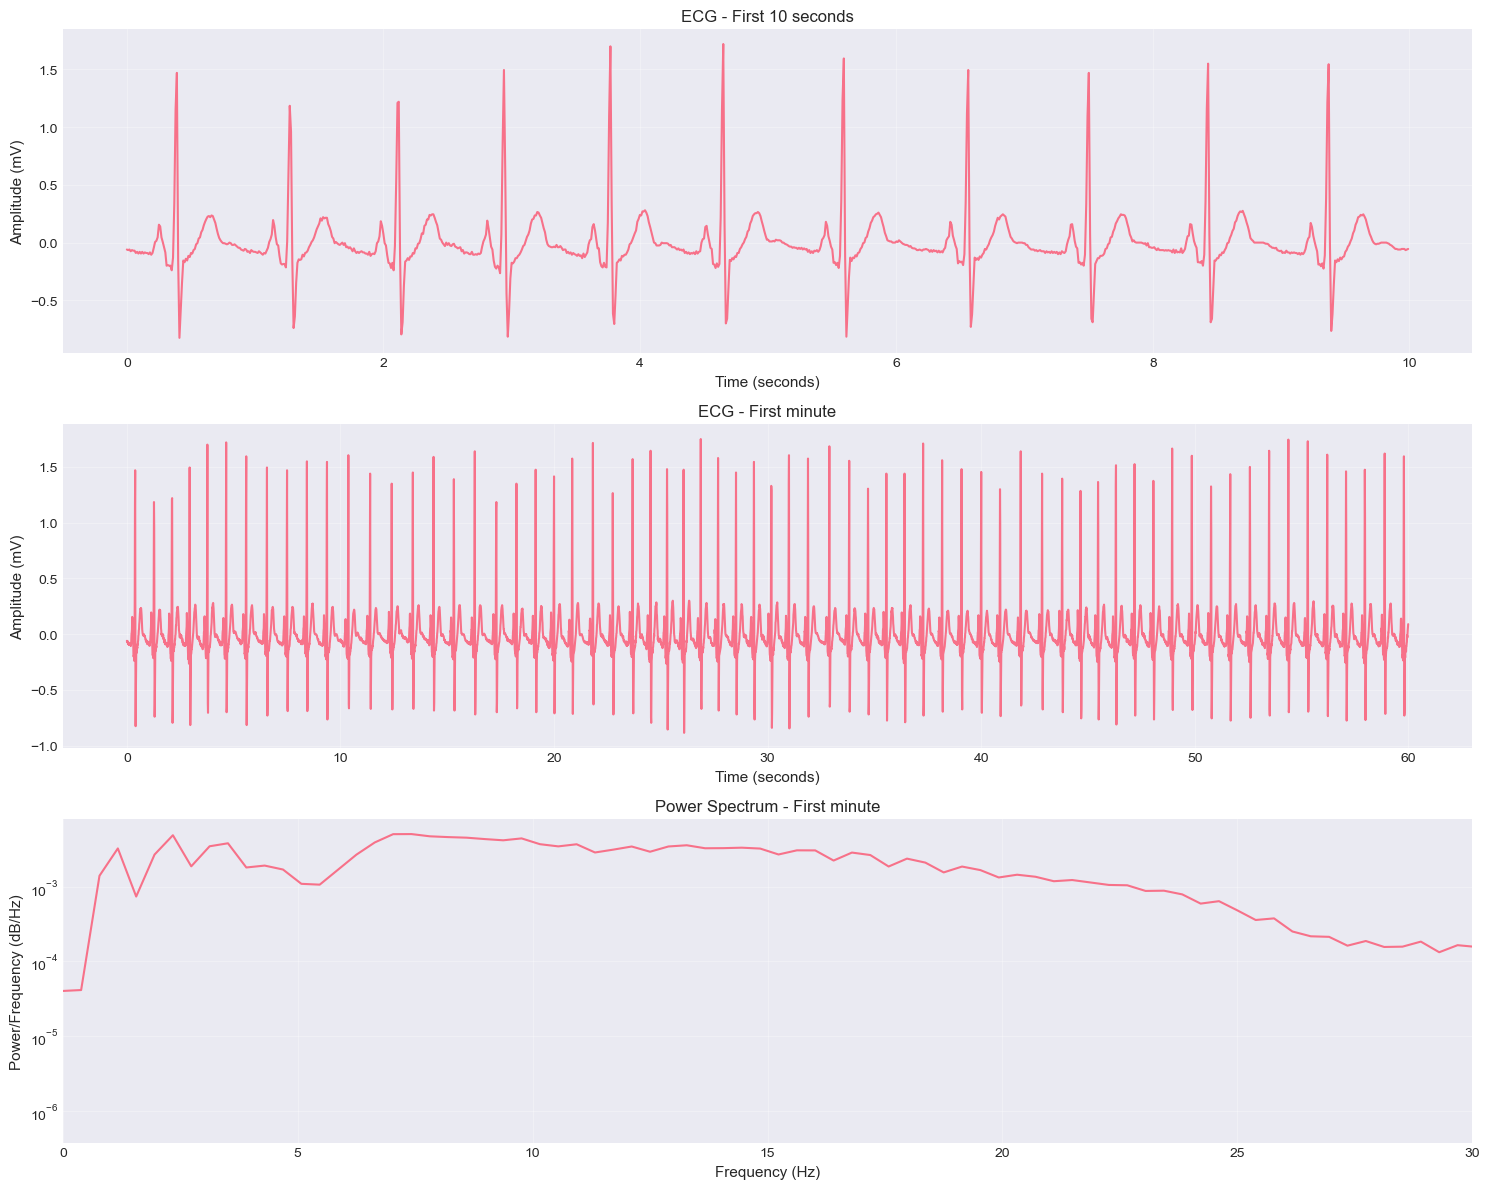

In [5]:
# Cell 5: Visualize ECG signal
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: First 10 seconds (1000 samples)
time_10s = np.arange(1000) / 100  # seconds
axes[0].plot(time_10s, ecg[:1000])
axes[0].set_title('ECG - First 10 seconds', fontsize=12)
axes[0].set_xlabel('Time (seconds)', fontsize=11)
axes[0].set_ylabel('Amplitude (mV)', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: First minute (6000 samples)
time_1min = np.arange(6000) / 100
axes[1].plot(time_1min, ecg[:6000])
axes[1].set_title('ECG - First minute', fontsize=12)
axes[1].set_xlabel('Time (seconds)', fontsize=11)
axes[1].set_ylabel('Amplitude (mV)', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Plot 3: Power Spectral Density
frequencies, psd = welch(ecg[:6000], fs=100, nperseg=256)
axes[2].semilogy(frequencies, psd)
axes[2].set_title('Power Spectrum - First minute', fontsize=12)
axes[2].set_xlabel('Frequency (Hz)', fontsize=11)
axes[2].set_ylabel('Power/Frequency (dB/Hz)', fontsize=11)
axes[2].set_xlim([0, 30])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

💓 Heart Rate Analysis (first 30 seconds):
   Estimated HR: 66.3 BPM
   HR variability: 5.44 BPM
   R-peaks found: 33
   Mean RR interval: 0.905s
   RR interval std: 0.072s


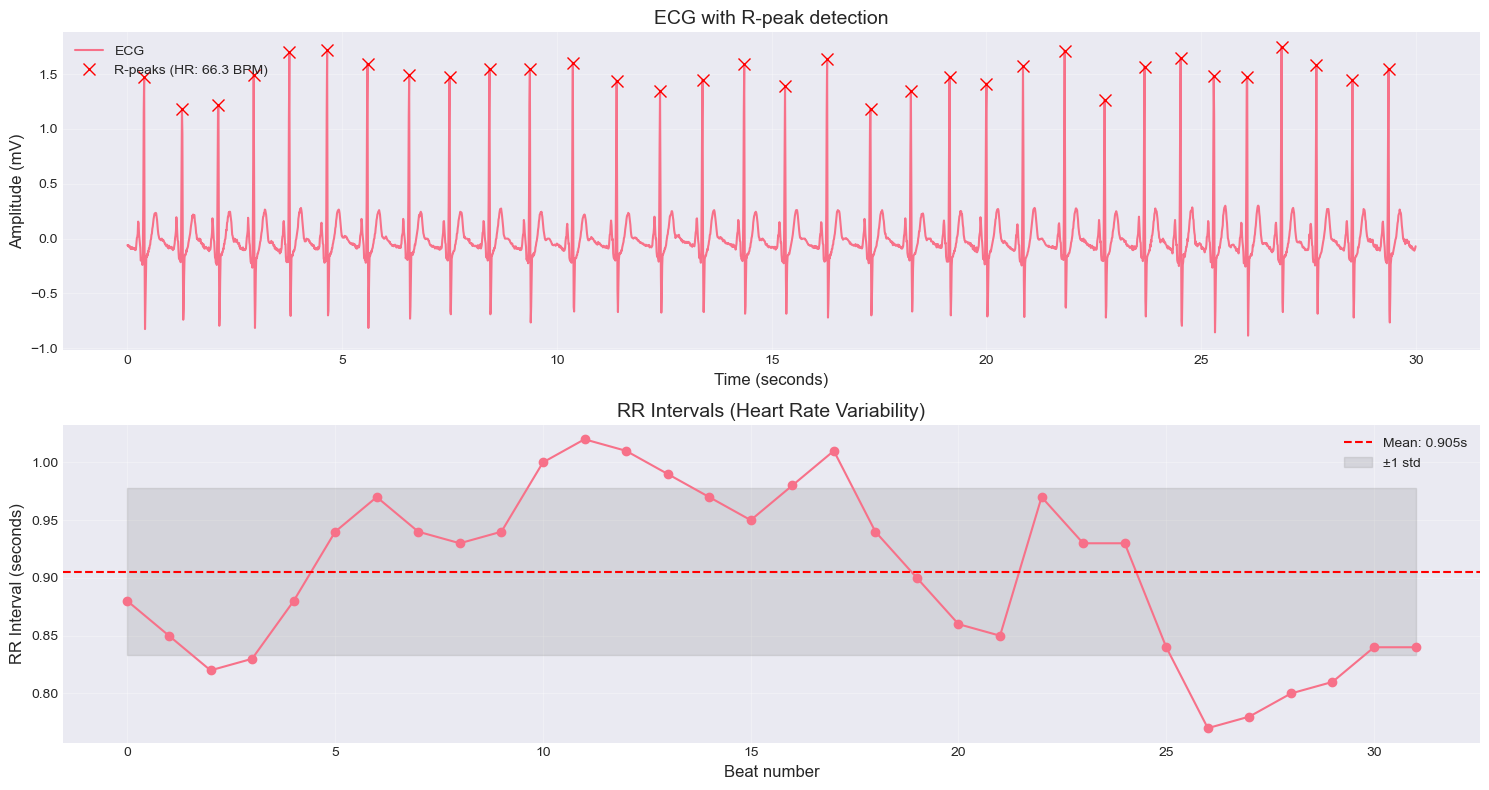

In [6]:
# Cell 6: Heart rate analysis
def estimate_heart_rate(ecg_segment, fs=100):
    """Estimate heart rate from ECG segment"""
    # Find R-peaks
    peaks, properties = find_peaks(ecg_segment, 
                                   distance=fs*0.5,  # Minimum 0.5s between beats
                                   prominence=0.1)   # Minimum peak prominence
    
    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / fs  # RR intervals in seconds
        heart_rate = 60 / np.mean(rr_intervals)  # BPM
        hr_std = np.std(60 / rr_intervals)  # Heart rate variability
        return heart_rate, hr_std, peaks, rr_intervals
    return None, None, peaks, None

# Analyze first 30 seconds
segment_30s = ecg[:3000]
hr, hr_std, peaks, rr_intervals = estimate_heart_rate(segment_30s)

if hr is not None:
    print(f"💓 Heart Rate Analysis (first 30 seconds):")
    print(f"   Estimated HR: {hr:.1f} BPM")
    print(f"   HR variability: {hr_std:.2f} BPM")
    print(f"   R-peaks found: {len(peaks)}")
    print(f"   Mean RR interval: {np.mean(rr_intervals):.3f}s")
    print(f"   RR interval std: {np.std(rr_intervals):.3f}s")
    
    # Plot with R-peaks
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    time_axis = np.arange(3000) / 100
    axes[0].plot(time_axis, segment_30s, label='ECG')
    axes[0].plot(time_axis[peaks], segment_30s[peaks], 'rx', 
                 label=f'R-peaks (HR: {hr:.1f} BPM)', markersize=8)
    axes[0].set_title('ECG with R-peak detection', fontsize=14)
    axes[0].set_xlabel('Time (seconds)', fontsize=12)
    axes[0].set_ylabel('Amplitude (mV)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot RR intervals
    axes[1].plot(rr_intervals, 'o-')
    axes[1].axhline(y=np.mean(rr_intervals), color='r', linestyle='--', 
                    label=f'Mean: {np.mean(rr_intervals):.3f}s')
    axes[1].fill_between(range(len(rr_intervals)), 
                         np.mean(rr_intervals) - np.std(rr_intervals),
                         np.mean(rr_intervals) + np.std(rr_intervals),
                         alpha=0.2, color='gray', label=f'±1 std')
    axes[1].set_title('RR Intervals (Heart Rate Variability)', fontsize=14)
    axes[1].set_xlabel('Beat number', fontsize=12)
    axes[1].set_ylabel('RR Interval (seconds)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Could not estimate heart rate - not enough R-peaks detected")

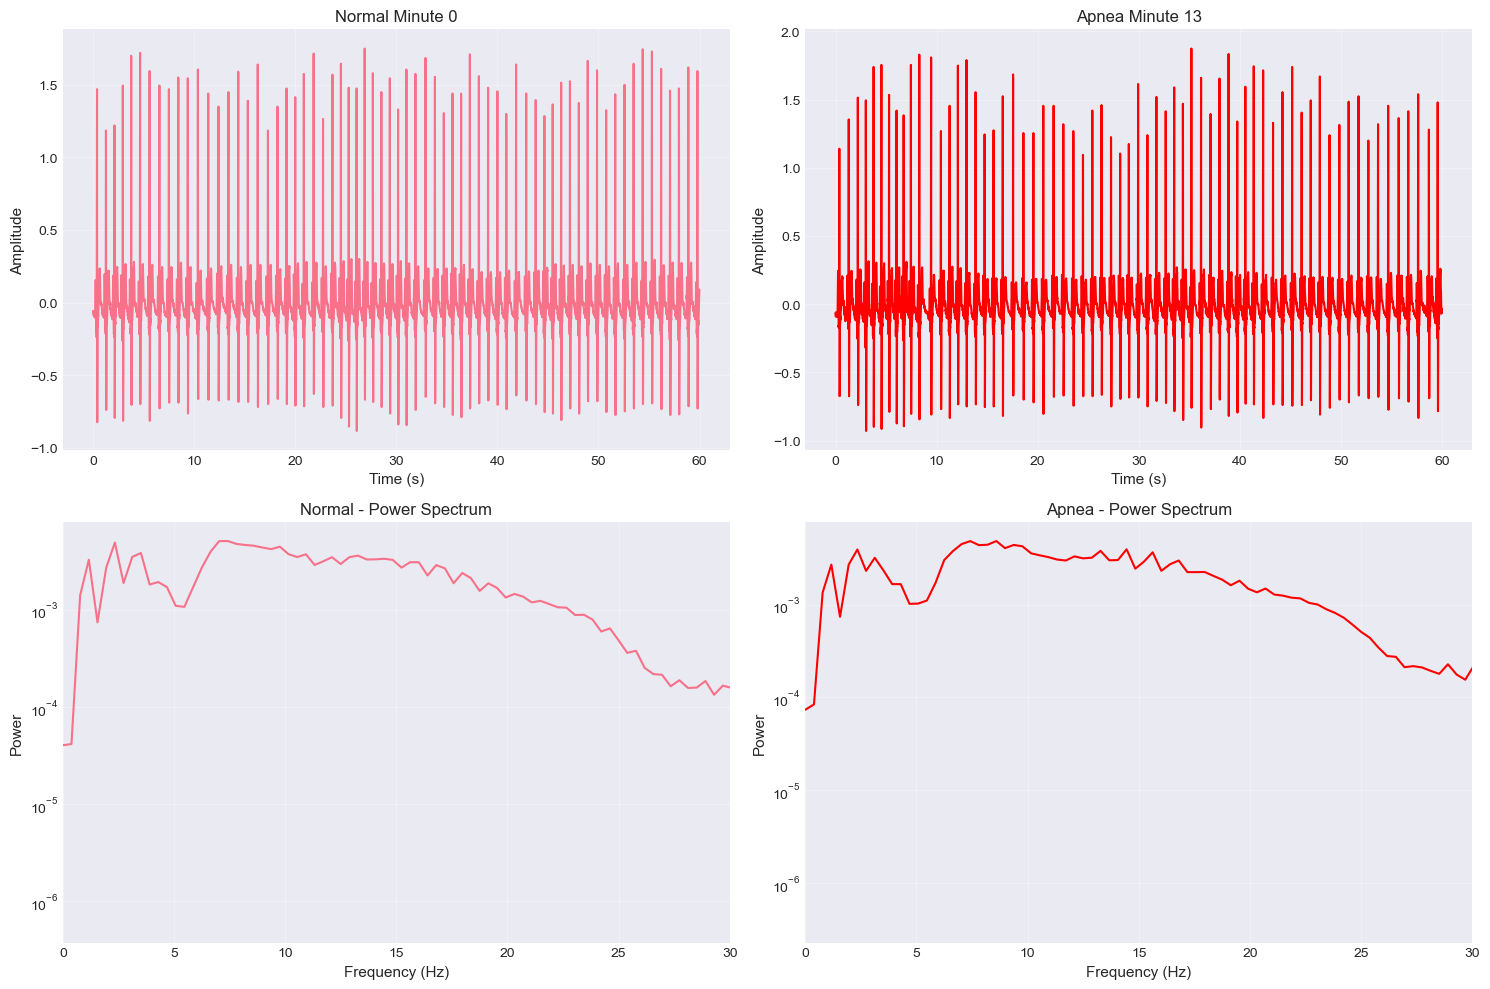

📊 ECG Segment Statistics Comparison:
--------------------------------------------------
Metric          Normal       Apnea        Difference  
--------------------------------------------------
Mean            -0.0009      0.0003       +0.0012 (-133.6%)
Std             0.2552       0.2510       -0.0042 (-1.6%)
Min             -0.8850      -0.9300      -0.0450 (+5.1%)
Max             1.7500       1.8750       +0.1250 (+7.1%)
Range           2.6350       2.8050       +0.1700 (+6.5%)
RMS             0.2552       0.2510       -0.0042 (-1.6%)


In [8]:
# Cell 7: Compare apnea vs normal ECG segments
if apnea_count > 0 and normal_count > 0:
    # Get example segments
    apnea_example = apnea_indices[0]  # First apnea minute (minute 13)
    normal_indices = np.where(labels == 'N')[0]
    normal_example = normal_indices[0]  # First normal minute
    
    # Extract 1-minute segments (6000 samples at 100 Hz)
    apnea_segment = ecg[apnea_example*6000:(apnea_example+1)*6000]
    normal_segment = ecg[normal_example*6000:(normal_example+1)*6000]
    
    time_axis = np.arange(6000) / 100
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Time domain
    axes[0, 0].plot(time_axis, normal_segment)
    axes[0, 0].set_title(f'Normal Minute {normal_example}', fontsize=12)
    axes[0, 0].set_xlabel('Time (s)', fontsize=11)
    axes[0, 0].set_ylabel('Amplitude', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(time_axis, apnea_segment, color='red')
    axes[0, 1].set_title(f'Apnea Minute {apnea_example}', fontsize=12)
    axes[0, 1].set_xlabel('Time (s)', fontsize=11)
    axes[0, 1].set_ylabel('Amplitude', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Frequency domain
    f_norm, psd_norm = welch(normal_segment, fs=100, nperseg=256)
    f_apn, psd_apn = welch(apnea_segment, fs=100, nperseg=256)
    
    axes[1, 0].semilogy(f_norm, psd_norm)
    axes[1, 0].set_title('Normal - Power Spectrum', fontsize=12)
    axes[1, 0].set_xlabel('Frequency (Hz)', fontsize=11)
    axes[1, 0].set_ylabel('Power', fontsize=11)
    axes[1, 0].set_xlim([0, 30])
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].semilogy(f_apn, psd_apn, color='red')
    axes[1, 1].set_title('Apnea - Power Spectrum', fontsize=12)
    axes[1, 1].set_xlabel('Frequency (Hz)', fontsize=11)
    axes[1, 1].set_ylabel('Power', fontsize=11)
    axes[1, 1].set_xlim([0, 30])
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics comparison
    print("📊 ECG Segment Statistics Comparison:")
    print("-" * 50)
    print(f"{'Metric':<15} {'Normal':<12} {'Apnea':<12} {'Difference':<12}")
    print("-" * 50)
    
    metrics = [
        ('Mean', normal_segment.mean(), apnea_segment.mean()),
        ('Std', normal_segment.std(), apnea_segment.std()),
        ('Min', normal_segment.min(), apnea_segment.min()),
        ('Max', normal_segment.max(), apnea_segment.max()),
        ('Range', np.ptp(normal_segment), np.ptp(apnea_segment)),  # Fixed: use np.ptp()
        ('RMS', np.sqrt(np.mean(normal_segment**2)), np.sqrt(np.mean(apnea_segment**2)))
    ]
    
    for name, norm_val, apn_val in metrics:
        diff = apn_val - norm_val
        diff_pct = (diff / norm_val * 100) if norm_val != 0 else 0
        print(f"{name:<15} {norm_val:<12.4f} {apn_val:<12.4f} {diff:+.4f} ({diff_pct:+.1f}%)")

📋 Loading first 10 records for dataset summary...

📊 Dataset Summary:
Record  ECG_Length  Duration_min  Total_Minutes  Apnea_Min  Normal_Min   Apnea_%  Other_Labels
   a01     2957000    492.833333            489        470          19 96.114519             0
   a02     3182000    530.333333            528        420         108 79.545455             0
   a03     3135000    522.500000            519        246         273 47.398844             0
   a04     2980000    496.666667            492        453          39 92.073171             0
   a05     2719500    453.250000            454        276         178 60.792952             0
   a06     3058000    509.666667            510        206         304 40.392157             0
   a07     3060500    510.083333            511        322         189 63.013699             0
   a08     3002500    500.416667            501        189         312 37.724551             0
   a09     2988000    498.000000            495        381         114 76.9

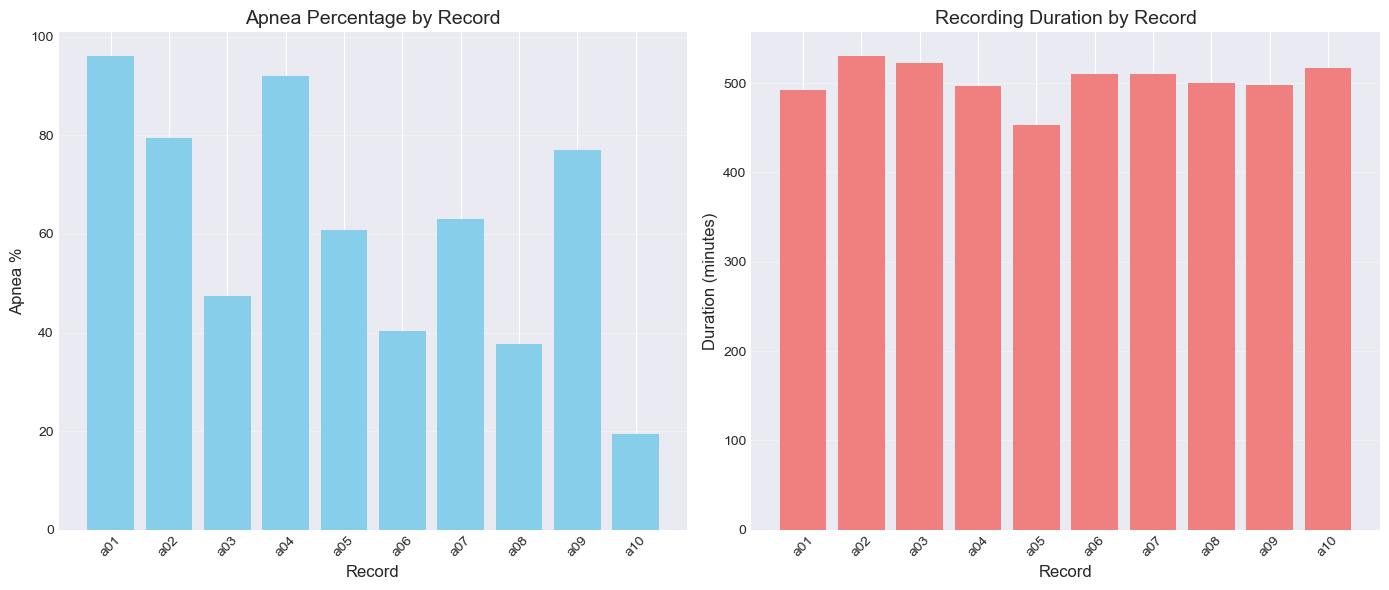


📈 Overall Dataset Statistics:
Total records analyzed: 10
Average recording duration: 503.1 minutes
Average apnea percentage: 61.3%
Total apnea minutes: 3063
Total normal minutes: 1953


In [9]:
# Cell 8: Load multiple records for summary
print("📋 Loading first 10 records for dataset summary...")

records_to_load = ['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10']
summary_data = []

for record in records_to_load:
    try:
        ecg_path = f'{data_dir}/{record}_ecg.npy'
        labels_path = f'{data_dir}/{record}_labels.npy'
        
        if os.path.exists(ecg_path) and os.path.exists(labels_path):
            ecg = np.load(ecg_path)
            labels = np.load(labels_path)
            
            apnea_count = np.sum(labels == 'A')
            normal_count = np.sum(labels == 'N')
            total_minutes = len(labels)
            
            summary_data.append({
                'Record': record,
                'ECG_Length': len(ecg),
                'Duration_min': len(ecg)/100/60,
                'Total_Minutes': total_minutes,
                'Apnea_Min': apnea_count,
                'Normal_Min': normal_count,
                'Apnea_%': apnea_count/total_minutes*100 if total_minutes > 0 else 0,
                'Other_Labels': len(labels) - apnea_count - normal_count
            })
        else:
            print(f"  ⚠ {record}: Files not found")
            
    except Exception as e:
        print(f"  ✗ {record}: Error - {e}")

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)
print("\n📊 Dataset Summary:")
print(summary_df.to_string(index=False))

# Plot summary
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Apnea percentage
axes[0].bar(summary_df['Record'], summary_df['Apnea_%'], color='skyblue')
axes[0].set_title('Apnea Percentage by Record', fontsize=14)
axes[0].set_xlabel('Record', fontsize=12)
axes[0].set_ylabel('Apnea %', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Duration
axes[1].bar(summary_df['Record'], summary_df['Duration_min'], color='lightcoral')
axes[1].set_title('Recording Duration by Record', fontsize=14)
axes[1].set_xlabel('Record', fontsize=12)
axes[1].set_ylabel('Duration (minutes)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📈 Overall Dataset Statistics:")
print(f"Total records analyzed: {len(summary_df)}")
print(f"Average recording duration: {summary_df['Duration_min'].mean():.1f} minutes")
print(f"Average apnea percentage: {summary_df['Apnea_%'].mean():.1f}%")
print(f"Total apnea minutes: {summary_df['Apnea_Min'].sum()}")
print(f"Total normal minutes: {summary_df['Normal_Min'].sum()}")